# 2.1.1嵌入表示层

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time

import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [31]:
class positionalencoder(nn.Module):
    def __init__(self, d_model, max_seq_len = 512):
        super(positionalencoder, self). __init__()
        self.d_model = d_model
        pe = torch.zeros(max_seq_len, d_model)
        # for pos in range(max_seq_len):
        #     for i in range(0, d_model, 2):
        #         pe[pos, i] = math.sin(pos / (10000 ** (2 * i / d_model)))
        #         pe[pos, i+1] = math.cos(pos / (10000 ** (2 * (i + 1) / d_model)))
        
        position = torch.arange(0, max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x = x * math.sqrt(self.d_model)
        x = x + self.pe[:, :x.size(1)]
        return x

    # 测试代码
d_model = 768
max_seq_len = 5000
encoder = positionalencoder(d_model, max_seq_len)

# 创建一个随机输入
input_data = torch.rand(2, 500, d_model)
print(input_data.shape)
# 通过模型
output = encoder(input_data)

# 打印输出的形状，以验证模型是否正确工作
print(output.shape)
# print(encoder.pe)

torch.Size([2, 500, 768])
torch.Size([2, 500, 768])


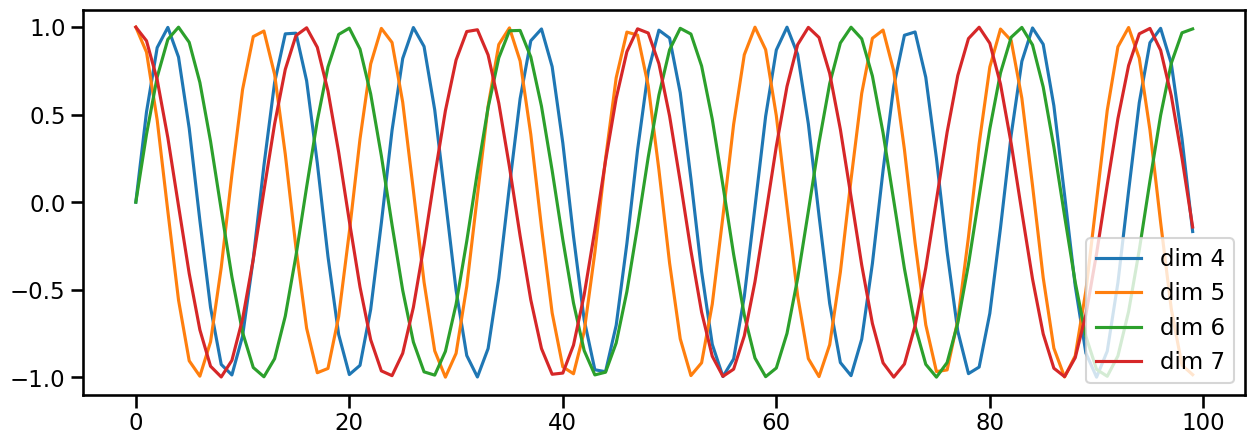

In [36]:
plt.figure(figsize=(15, 5))
pe = positionalencoder(60, 5000)
y = pe.forward(torch.zeros(1, 100, 60))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

# 2.1.2 多头注意力机制

In [45]:
def attention(q, k, v, mask = None, dropout = None):
    d_k = q.size(-1)
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        scores = dropout(scores)
    return torch.matmul(p_attn, v) , p_attn

q = torch.rand(2, 500, 12, 64)
k = torch.rand(2, 500, 12, 64)
v = torch.rand(2, 500, 12, 64)
result, patt = attention(q, k, v)
result.shape

torch.Size([2, 500, 12, 64])

In [46]:
class mutiheadattention(nn.Module):
    def __init__(self, head, d_model, dropout = 0.1):
        self.d_model = d_model
        self.d_k = d_model // head
        self.head = head
        self.dropout = dropout
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.output = nn.Linear(d_model, d_model)
        
    def attention(q, k, v ,d_k, mask = None, dropout = None):

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            mask = mask.unsqueeze(1)
            scores = scores.masked_fill(mask == 0, -1e9)
        p_attn = F.softmax(scores, dim = -1)
        if dropout is not None:
            scores = dropout(scores)
        return torch.matmul(p_attn, v), p_attn
    
    def forward(self, q, k, v, mask):
        bs = q.size(0)
        q = self.q_linear(q).view(bs, -1, self.head, self.d_k)
        k = self.k_linear(k).view(bs, -1, self.head, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.head, self.d_k)
        
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        
        scores, attn = attention(q, k, v, self.d_k, mask, self.dropout)
        scores = scores.transpose(1, 2).contiguous().view(bs, -1, self.d_model)
        out = self.output(scores)
        return out
        